## Задание 1. A/B–тестирование
**1.1 Условие**

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**1.2 Входные данные**

В качестве входных данных Вы имеете 4 csv-файла:

- *groups.csv* - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- *groups_add.csv* - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- *active_studs.csv* - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- *checks.csv* - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

**1.3 Вопросы**

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

**1.4 Требования к ответу**

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

import requests
import json
from urllib.parse import urlencode

from scipy.stats import mannwhitneyu, norm
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(rc={'figure.figsize': (10, 6)}, style="whitegrid")

### Считываем данные

In [2]:
groups_public_key = 'https://yadi.sk/d/58Us0DWOzuWAjg'  # Ссылка на groups.csv
groups_add_public_key = 'https://yadi.sk/d/3aARY-P9pfaksg'  # Ссылка на groups_add.csv
active_studs_public_key = 'https://yadi.sk/d/prbgU-rZpiXVYg'  # Ссылка на active_studs.csv
checks_public_key = 'https://yadi.sk/d/84hTmELphW2sqQ'  # Ссылка на checks.csv

In [3]:
# Функция считывания данных с Яндекс.Диск
def read_data(public_key, sep=';'):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = json.loads(response.text)['href']  # 'парсинг' ссылки на скачивание
    
    # Загружаем файл и сохраняем его в df
    df = pd.read_csv(download_url, sep=sep, error_bad_lines=False, comment='#')
    return df

In [4]:
# Считываем данные
groups = read_data(groups_public_key)
groups_add = read_data(groups_add_public_key, sep=',')
active_studs = read_data(active_studs_public_key)
checks = read_data(checks_public_key)

### Какие данные у нас имеются? 
Размеры датафреймов, типы данных, количество пропущенных значений

In [5]:
# Размеры скачанных данных
print('Размеры groups.csv:', groups.shape)
print('Размеры groups_add.csv:', groups_add.shape)
print('Размеры active_studs.csv:', active_studs.shape)
print('Размеры checks.csv:', checks.shape)

Размеры groups.csv: (74484, 2)
Размеры groups_add.csv: (92, 2)
Размеры active_studs.csv: (8341, 1)
Размеры checks.csv: (541, 2)


In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

In [8]:
# Количество пропущенных значений
groups.isna().sum()

id     0
grp    0
dtype: int64

In [9]:
# Проверка на дубликаты
groups.id.count() == groups.id.nunique()

True

In [10]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [12]:
# Количество пропущенных значений
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [13]:
# Проверка на дубликаты
groups_add.id.count() == groups_add.id.nunique()

True

In [14]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [15]:
active_studs.dtypes

student_id    int64
dtype: object

In [16]:
# Проверка на дубликаты
active_studs.student_id.count() == active_studs.student_id.nunique()

True

In [17]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [19]:
# Количество пропущенных значений
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [20]:
# Проверка на дубликаты
checks.student_id.count() == checks.student_id.nunique()

True

### Подготовка данных

In [21]:
# Объединяем данные из groups и groups_add в один df
full_groups = pd.concat([groups, groups_add])
full_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [22]:
# Проверка на дубликаты
full_groups.id.count() == full_groups.id.nunique()

True

In [23]:
# Соотношение размеров групп
full_groups.value_counts(subset='grp', normalize=True).mul(100).round(2)

grp
B    80.3
A    19.7
dtype: float64

In [24]:
# Переименуем колонку student_id в id
active_studs.rename(columns={'student_id': 'id'}, inplace=True)
checks.rename(columns={'student_id': 'id'}, inplace=True)

active_studs['active'] = 1

In [25]:
# Собираем полный DF
full_data = full_groups.merge(active_studs, how='left')
full_data = full_data.merge(checks, how='left').fillna(0)
full_data.head()

,id,grp,active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [26]:
# Количество пользователей в группах
group_size = full_data.groupby('grp', as_index=False) \
    .agg({'id': 'count'})

a_full_size = group_size.id.values[0]  # Размер группы A
b_full_size = group_size.id.values[1]  # Размер группы B

group_size

,grp,id
0,A,14693
1,B,59883


In [27]:
# Количество активных пользователей в группах
active_size = full_data.query('active == 1') \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'})

a_active_size = active_size.id.values[0]  # Количество активных пользователей в группе A
b_active_size = active_size.id.values[1]  # Количество активных пользователей в группе B

active_size

,grp,id
0,A,1538
1,B,6803


In [28]:
# Количество покупателей в группах
buyers_size = full_data.query('rev > 0') \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'})

a_buyers_size = buyers_size.id.values[0]  # Количество покупателей в группе A
b_buyers_size = buyers_size.id.values[1]  # Количество покупателей в группе B

buyers_size

,grp,id
0,A,107
1,B,434


In [29]:
# Необъяснимо, но факт
# Пользователи, которые не были активны, но совершили покупку
full_data.query('active == 0 and rev > 0') \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count'})

,grp,id
0,A,29
1,B,120


### Анализ данных


Исходя из имеющихся данных, для рассмотрения были выбраны следующие метрики:
- Конверсия пользователя в покупку
- Конверсия активного пользователя в покупку
- ARPU
- ARPPU
- ARPAU (доход с активного пользователя)
- Медианный доход с покупателя

Главное для бизнеса - рост выручки и чистой прибыли. Данные метрики покажут, как введение новой механики отразилось на доходах компании.

In [30]:
# CR пользователей в покупку
# Для группы А
cr_a = round((a_buyers_size / a_full_size) * 100, 2)  # Кол-во покупателей / Кол-во всех пользователей
print(f'CR пользователей группы A в покупку {cr_a}%')

# Для группы Б
cr_b = round((b_buyers_size / b_full_size) * 100, 2)  # Кол-во покупателей / Кол-во всех пользователей
print(f'CR пользователей группы B в покупку {cr_b}%')

# CR активных пользователей в покупку
# Для группы А
cr_active_a = round((a_buyers_size / a_active_size) * 100, 2)  # Кол-во покупателей / Кол-во активных пользователей
print(f'CR активных пользователей группы A в покупку {cr_active_a}%')

# Для группы Б
cr_active_b = round((b_buyers_size / b_active_size) * 100, 2)  # Кол-во покупателей / Кол-во активных пользователей
print(f'CR активных пользователей группы B в покупку {cr_active_b}%')

CR пользователей группы A в покупку 0.73%
CR пользователей группы B в покупку 0.72%
CR активных пользователей группы A в покупку 6.96%
CR активных пользователей группы B в покупку 6.38%


In [31]:
# Процент активных пользователей в дни проведения теста
# Для группы А
active_a = round((a_active_size / a_full_size) * 100, 2)  # Кол-во активных пользователей / Кол-во всех пользователей
print(f'{active_a}% пользователей группы A были активными в дни проведения теста')

# Для группы Б
active_b = round((b_active_size / b_full_size) * 100, 2)  # Кол-во активных пользователей / Кол-во всех пользователей
print(f'{active_b}% пользователей группы B были активными в дни проведения теста')

10.47% пользователей группы A были активными в дни проведения теста
11.36% пользователей группы B были активными в дни проведения теста


In [32]:
# Доходы с каждой из групп
revenue = full_data.groupby('grp', as_index=False).agg({'rev': 'sum'})

revenue['users'] = group_size.id
revenue['active_users'] = active_size.id
revenue['buyers'] = buyers_size.id

# ARPU в дни проведения теста
revenue['ARPU'] = round(revenue.rev / revenue.users, 2)
# ARPAU в дни проведения теста
revenue['ARPAU'] = round(revenue.rev / revenue.active_users, 2)
# ARPPU в дни проведения теста
revenue['ARPPU'] = round(revenue.rev / revenue.buyers, 2)
# Медианная чек покупателей в дни проведения теста
revenue['median_check'] = full_data.query('rev > 0') \
    .groupby('grp', as_index=False) \
    .agg({'rev': 'median'}) \
    .rev.values

revenue

,grp,rev,users,active_users,buyers,ARPU,ARPAU,ARPPU,median_check
0,A,92096.0000,14693,1538,107,6.27,59.88,860.71,690.0
1,B,481230.0036,59883,6803,434,8.04,70.74,1108.82,935.0


In [33]:
# Изменение ARPU в %
arpu_diff = round((revenue.ARPU.iloc[1] / revenue.ARPU.iloc[0] - 1) * 100, 2)
print(f'ARPU в тестовой группе выросло на {arpu_diff}%')

# Изменение ARPAU в %
arpau_diff = round((revenue.ARPAU.iloc[1] / revenue.ARPAU.iloc[0] - 1) * 100, 2)
print(f'ARPAU в тестовой группе вырос на {arpau_diff}%')

# Изменение ARPPU в %
arppu_diff = round((revenue.ARPPU.iloc[1] / revenue.ARPPU.iloc[0] - 1) * 100, 2)
print(f'ARPPU в тестовой группе вырос на {arppu_diff}%')

# Изменение медианного чека покупателя в %
median_diff = round((revenue.median_check.iloc[1] / revenue.median_check.iloc[0] - 1) * 100, 2)
print(f'Медианный чек в тестовой группе выросла на {median_diff}%')

ARPU в тестовой группе выросло на 28.23%
ARPAU в тестовой группе вырос на 18.14%
ARPPU в тестовой группе вырос на 28.83%
Медианный чек в тестовой группе выросла на 35.51%


### Распределение выборок

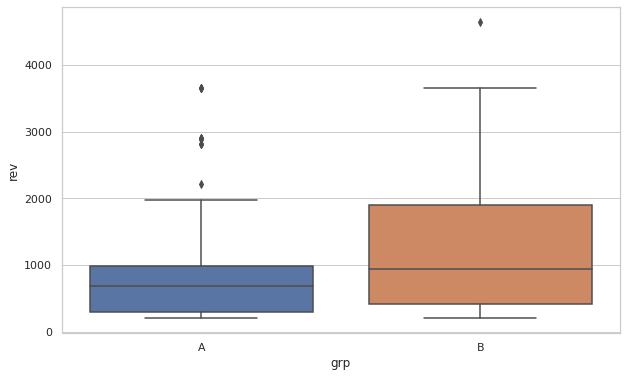

In [34]:
# Boxplot по сумме покупок для каждой группы
sns.boxplot(x="grp", y="rev", data=full_data.query('rev > 0'))

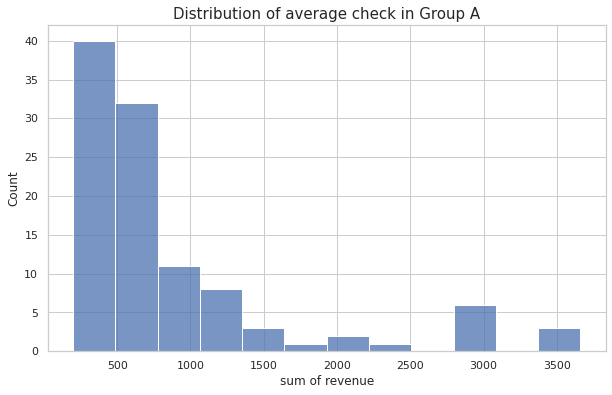

In [35]:
# Распределение суммы покупок в группе A
ax = sns.histplot(data=full_data.query('(grp == "A") and (rev > 0)'), x='rev')

plt.title('Distribution of average check in Group A', fontdict={'fontsize': 15})
plt.xlabel('sum of revenue')
plt.show()

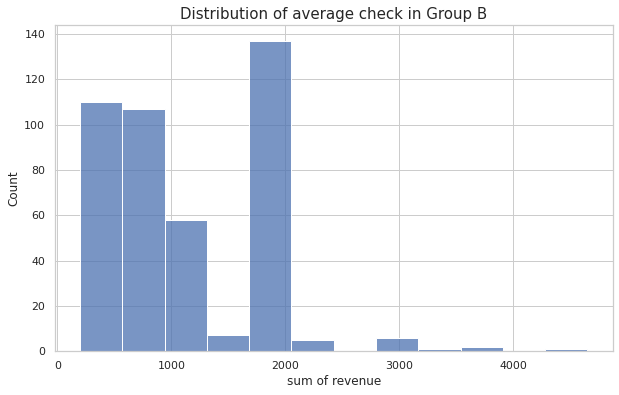

In [36]:
# Распределение суммы покупок в группе B
ax = sns.histplot(data=full_data.query('(grp == "B") and (rev > 0)'), x='rev')

plt.title('Distribution of average check in Group B', fontdict={'fontsize': 15})
plt.xlabel('sum of revenue')
plt.show()

*Распределение в группах сильно отличается от нормального. Для проверки равенства распределений используем **U-Критерий Манна-Уитни**.*
*Для сравнения ARPAU, ARPPU и медианной суммы дохода с покупателя воспользуемся методом **bootstrap**.*

### U-Критерий Манна-Уитни
* Нулевая гипотеза H0: равенство распределений соблюдается
* Альернативная гипотеза H1: равенство распределений не соблюдается
* a = 0.05

In [37]:
mannwhitneyu(full_data.query('(grp == "A") and (rev > 0)').rev,
             full_data.query('(grp == "B") and (rev > 0)').rev)

MannwhitneyuResult(statistic=17862.0, pvalue=0.00019316054996380152)

*Вывод: поскольку p-value = 0.00019 < a = 0.05, то мы может  сделать вывод о том, что  равенство распределений в выборках не соблюдается*

### Bootstrap
#### Гипотезы:

**Доход на активного пользователя**:
* Нулевая гипотеза H0: Доходы на активного пользователя в группах равны
* Альтернативная гипотеза H1: Доходы на активного пользователя в группах различаются
* a = 0.05

**ARPPU**:
* Нулевая гипотеза H0: ARPPU в группах равны
* Альтернативная гипотеза H1: ARPPU в группах различаются
* a = 0.05

**Медианная сумма покупок у пользователей, совершивших покупку**:
* Нулевая гипотеза H0: Медианные суммы покупок в группах у пользователей, совершивших покупку, равны
* Альтернативная гипотеза H1: Медианные суммы покупок в группах у пользователей, совершивших покупку, различаются
* a = 0.05

In [38]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(8, 5))
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=150, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

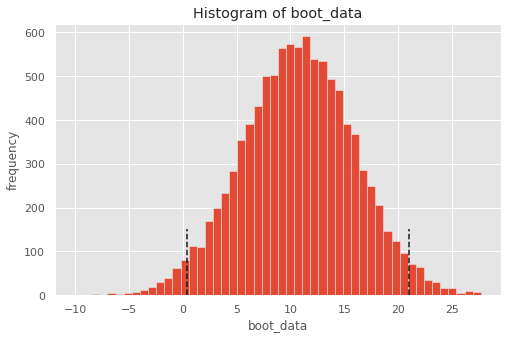

In [226]:
# bootstrap для средних значений ARPAU
active_booted_mean = get_bootstrap(full_data.query('grp == "B" and active == 1').rev,  # Тестовая группа
                                   full_data.query('grp == "A" and active == 1').rev,  # Контрольная группа
                                   boot_it=10000,  # Количество бутстрэп-подвыборок
                                   statistic=np.mean)  # Статистика для сравнения

In [227]:
# p-value различий ARPAU
active_booted_mean['p_value']

0.03941394993681733

In [228]:
# Доверительный интервал прироста ARPAU
active_booted_mean['ci']

,0
0.025,0.342316
0.975,21.004873


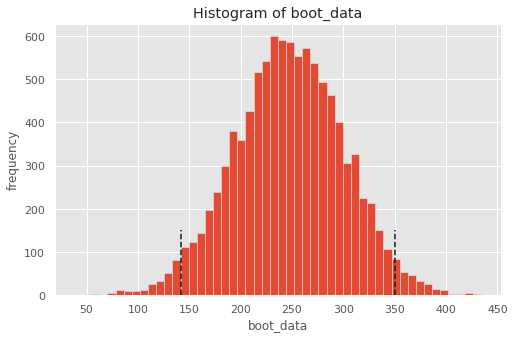

In [229]:
# bootstrap для средних значений ARPPU
arppu_booted_mean = get_bootstrap(full_data.query('grp == "B" and rev > 0').rev,  # Тестовая группа
                                  full_data.query('grp == "A" and rev > 0').rev,  # Контрольная группа
                                  boot_it=10000,  # Количество бутстрэп-подвыборок
                                  statistic=np.mean)  # Статистика для сравнения

In [230]:
# p-value различий ARPPU
arppu_booted_mean['p_value']

3.4563942767200306e-06

In [231]:
# Доверительный интервал прироста ARPPU
arppu_booted_mean['ci']

,0
0.025,142.220460
0.975,349.952541


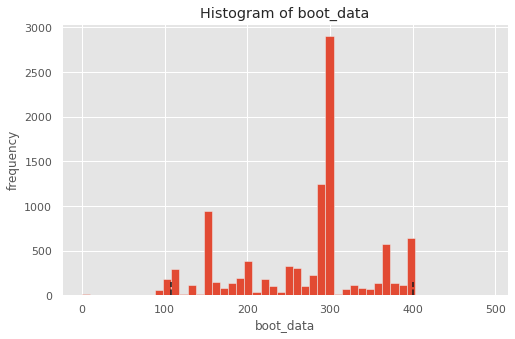

In [232]:
# bootstrap для медианных значений выручки с покупателя
arppu_booted_median = get_bootstrap(full_data.query('grp == "B" and rev > 0').rev,  # Тестовая группа
                                    full_data.query('grp == "A" and rev > 0').rev,  # Контрольная группа
                                    boot_it=10000,  # Количество бутстрэп-подвыборок
                                    statistic=np.median)  # Статистика для сравнения

In [233]:
# p-value различий медианных значений выручки с покупателя
arppu_booted_median['p_value']

0.0008339264400387106

In [234]:
# Доверительный интервал прироста медианных значений выручки с покупателя
arppu_booted_median['ci']

,0
0.025,108.0
0.975,400.0


### Вывод:
*Что мы имеем в итоге?*:
- Снижение конверсии активных пользователей в покупку с 6.96% (контроль) до 6.38% (тест)
- ARPU в тестовой группе выросло на 28.23%
- ARPAU в тестовой группе вырос на 18.14%
- ARPPU в тестовой группе вырос на 28.83%
- Медианный чек покупателя в тестовой группе выросла на 35.51%

Методом bootstrap мы выяснили, что различия ARPAU, ARPPU и медианных значений выручки с покупателя являются *статистически значимыми*:
- ARPAU: 
    - pvalue: 0.039 < 0.05
    - Доверительные интервал: [0.34, 21.00]
- ARPPU:
    - pvalue: 3.46*$10^{-6}$ < 0.05
    - Доверительные интервал: [142.22, 349.95]
- Медианное значение выручки с покупателя:
    - pvalue: 0.0008 < 0.05
    - Доверительные интервал: [108, 400]

Также необходимо отметить, что распределение групп выглядит довольно странным (тестовая группа - 80%, контрольная группа - 20%) и есть пользователи, которые не были активными, но совершили покупку (возможно, это ложно повлияло на снижение конверсии среди активных пользователей).

**Таким образом, не смотря на снижение конверсии, удалось статистически значимо увеличить ARPAU, ARPPU и медианное значение выручки с покупателя, что говорит нам об изменении метрик не только за счет выбросов в данных. Это произошло из-за увеличения среднего чека (на графиках распределения суммы чеков видно, что в тестовой группе сильно выросло процентное соотношение чеков на сумму ~ 2000).
Новую механику рекомендуется запустить на всех пользователей.**

## Задание 3. Python
* Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
* Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### Функция добавления данных и пересчета метрик

In [39]:
# Функция добавляет новые данные из groups_add.csv и пересчитывает метрики
def add_new_data(groups_add_public_key, groups, active_studs, checks):
    # Скачиваем данные с Яндекс.Диск с помощью функции read_data()
    groups_add = read_data(groups_add_public_key, sep=',')
    
    # Объединем всех пользователе в общий DataFrame
    full_groups = pd.concat([groups, groups_add.rename(columns={groups_add.columns[0]: 'id',
                                                                groups_add.columns[1]: 'grp'})])
    # Обновлем индексы
    full_groups = full_groups.reset_index(drop=True)
    
    # Переименуем колонку student_id в id
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)
    
    active_studs['active'] = 1
    
    # Полный df
    df = full_groups.merge(active_studs, how='left').merge(checks, how='left').fillna(0)
     
    # Создаем таблицу с метриками
    # Кол-во пользователей в каждой группе
    metrics = df.groupby('grp', as_index=False).agg({'id': 'count'}).rename(columns={'id': 'users'})  
    # Кол-во активных пользователей
    metrics['active_users'] = df.query('active == 1').groupby('grp', as_index=False).agg({'id': 'count'}).id.values    
    # Кол-во покупателей
    metrics['buyers'] = df.query('rev > 0').groupby('grp', as_index=False).agg({'id': 'count'}).id.values    
    # Общая выручка с каждой группы
    metrics['revenue'] = df.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev.values
    # ARPU
    metrics['ARPU'] = round(metrics.revenue / metrics.users, 2)    
    # ARPAU
    metrics['ARPAU'] = round(metrics.revenue / metrics.active_users, 2)    
    # ARPPU
    metrics['ARPPU'] = round(metrics.revenue / metrics.buyers, 2)    
    # Медианный чек
    metrics['median_check'] = full_data.query('rev > 0') \
        .groupby('grp', as_index=False) \
        .agg({'rev': 'median'}) \
        .rev.values    
    # Конверсия пользователя в покупку
    metrics['cr'] = round((metrics.buyers / metrics.users) * 100, 2)    
    # Конверсия активного пользователя в покупку
    metrics['cr_active'] = round((metrics.buyers / metrics.active_users) * 100, 2)   
        
    return metrics

In [40]:
metrics = add_new_data(groups_add_public_key, groups, active_studs, checks)

In [41]:
metrics

,grp,users,active_users,buyers,revenue,ARPU,ARPAU,ARPPU,median_check,cr,cr_active
0,A,14693,1538,107,92096.0000,6.27,59.88,860.71,690.0,0.73,6.96
1,B,59883,6803,434,481230.0036,8.04,70.74,1108.82,935.0,0.72,6.38


### Функция построения графиков

In [83]:
# Строим графики по полученным метрикам
def get_plots(metrics):
    # ARPU
    plt.subplot(2, 3, 1)
    bar = sns.barplot(y='ARPU', x='grp', data=metrics)
    bar.axes.set_title("ARPU", fontsize=16)
    bar.set_xlabel("Группа", fontsize=12)
    bar.set_ylabel("Значения", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(w_pad=2)
    
    # ARPAU
    plt.subplot(2, 3, 2)
    bar = sns.barplot(y='ARPAU', x='grp', data=metrics)
    bar.axes.set_title("ARPAU", fontsize=16)
    bar.set_xlabel("Группа", fontsize=12)
    bar.set_ylabel("Значения", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(w_pad=2)
    
    # ARPPU
    plt.subplot(2, 3, 3)
    bar = sns.barplot(y='ARPPU', x='grp', data=metrics)
    bar.axes.set_title("ARPPU", fontsize=16)
    bar.set_xlabel("Группа", fontsize=12)
    bar.set_ylabel("Значения", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(w_pad=2)
    
    # Медианный чек
    plt.subplot(2, 3, 4)
    bar = sns.barplot(y='median_check', x='grp', data=metrics)
    bar.axes.set_title("Медианный чек", fontsize=16)
    bar.set_xlabel("Группа", fontsize=12)
    bar.set_ylabel("Значения", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(w_pad=2)
    
    # Конверсия в покупку
    plt.subplot(2, 3, 5)
    bar = sns.barplot(y='cr', x='grp', data=metrics)
    bar.axes.set_title("Конверсия пользователей\n в покупку", fontsize=16)
    bar.set_xlabel("Группа", fontsize=12)
    bar.set_ylabel("Значения", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(w_pad=2)
    
    # Конверсия активных пользователей в покупку
    plt.subplot(2, 3, 6)
    bar = sns.barplot(y='cr_active', x='grp', data=metrics)
    bar.axes.set_title("Конверсия активных\n пользователей в покупку", fontsize=16)
    bar.set_xlabel("Группа", fontsize=12)
    bar.set_ylabel("Значения", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(w_pad=2)

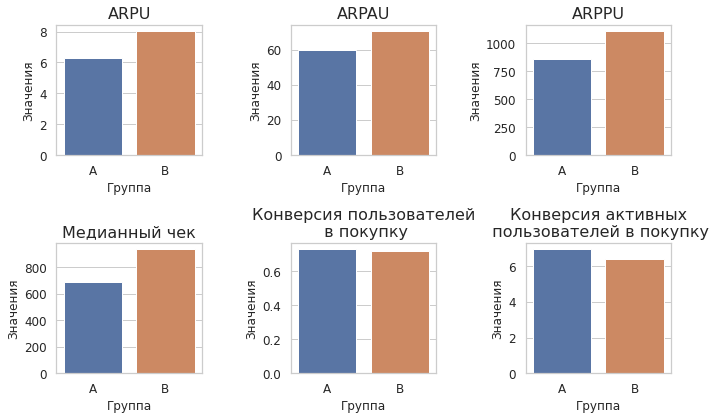

In [85]:
# Применим функцию построения графиков
get_plots(metrics)